In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
from sklearn.metrics import confusion_matrix

class LandUseAnalysis:
    def __init__(self, shapefile_path):
        """
        กำหนดค่าเริ่มต้นสำหรับการวิเคราะห์
        """
        self.study_area = gpd.read_file(shapefile_path)
        self.land_use_categories = {
            1: 'พื้นที่เกษตรกรรม',
            2: 'พื้นที่ป่าไม้',
            3: 'พื้นที่เมือง',
            4: 'แหล่งน้ำ',
            5: 'พื้นที่อื่นๆ'
        }
    
    def load_satellite_data(self, raster_path, year):
        """
        โหลดข้อมูลภาพถ่ายดาวเทียม
        """
        with rasterio.open(raster_path) as src:
            self.satellite_data = src.read()
            self.metadata = src.meta
            self.year = year
    
    def classify_land_use(self):
        """
        จำแนกประเภทการใช้ประโยชน์ที่ดิน
        """
        # สมมติว่าใช้วิธีการจำแนกแบบง่าย (ในความเป็นจริงควรใช้ machine learning)
        classified = np.zeros_like(self.satellite_data[0])
        
        # ตัวอย่างการจำแนกอย่างง่าย
        ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])
        
        classified[ndvi > 0.5] = 2  # ป่าไม้
        classified[ndvi < 0] = 4    # แหล่งน้ำ
        classified[(ndvi >= 0) & (ndvi <= 0.2)] = 3  # เมือง
        classified[(ndvi > 0.2) & (ndvi <= 0.5)] = 1  # เกษตรกรรม
        
        self.classified_data = classified
        return classified
    
    def calculate_area_statistics(self):
        """
        คำนวณสถิติพื้นที่แต่ละประเภท
        """
        stats = {}
        pixel_area = abs(self.metadata['transform'][0] * self.metadata['transform'][4])
        
        for code, name in self.land_use_categories.items():
            area = np.sum(self.classified_data == code) * pixel_area
            percentage = (area / (self.metadata['width'] * self.metadata['height'] * pixel_area)) * 100
            stats[name] = {
                'area_sq_km': area / 1000000,  # แปลงเป็น ตร.กม.
                'percentage': percentage
            }
        
        return pd.DataFrame(stats).T
    
    def create_change_matrix(self, old_classification, new_classification):
        """
        สร้าง matrix แสดงการเปลี่ยนแปลงการใช้ประโยชน์ที่ดิน
        """
        matrix = confusion_matrix(old_classification.flatten(), 
                                new_classification.flatten(),
                                labels=list(self.land_use_categories.keys()))
        
        df_matrix = pd.DataFrame(matrix,
                               index=[f'From {v}' for v in self.land_use_categories.values()],
                               columns=[f'To {v}' for v in self.land_use_categories.values()])
        return df_matrix
    
    def plot_results(self):
        """
        สร้างแผนที่และกราฟแสดงผลการวิเคราะห์
        """
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # แผนที่การใช้ประโยชน์ที่ดิน
        im = ax1.imshow(self.classified_data, cmap='Set3')
        ax1.set_title(f'การใช้ประโยชน์ที่ดิน ปี {self.year}')
        
        # สร้าง legend
        patches = [plt.plot([], [], marker="s", ms=10, ls="", color=plt.cm.Set3(i/5.), 
                          label=name)[0] for i, name in self.land_use_categories.items()]
        ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        # กราฟแสดงสัดส่วนพื้นที่
        stats = self.calculate_area_statistics()
        stats['percentage'].plot(kind='bar', ax=ax2)
        ax2.set_title('สัดส่วนการใช้ประโยชน์ที่ดิน')
        ax2.set_ylabel('ร้อยละ')
        
        plt.tight_layout()
        return fig

def run_analysis(shapefile_path, raster_path_2010, raster_path_2020):
    """
    ฟังก์ชันหลักสำหรับการวิเคราะห์
    """
    # สร้าง instance สำหรับการวิเคราะห์
    analysis = LandUseAnalysis(shapefile_path)
    
    # วิเคราะห์ข้อมูลปี 2010
    analysis.load_satellite_data(raster_path_2010, 2010)
    classification_2010 = analysis.classify_land_use()
    stats_2010 = analysis.calculate_area_statistics()
    
    # วิเคราะห์ข้อมูลปี 2020
    analysis.load_satellite_data(raster_path_2020, 2020)
    classification_2020 = analysis.classify_land_use()
    stats_2020 = analysis.calculate_area_statistics()
    
    # วิเคราะห์การเปลี่ยนแปลง
    change_matrix = analysis.create_change_matrix(classification_2010, classification_2020)
    
    # สร้างแผนที่และกราฟ
    fig = analysis.plot_results()
    
    return stats_2010, stats_2020, change_matrix, fig

In [ ]:
stats_2010, stats_2020, change_matrix, figures = run_analysis(
    'path/to/study_area.shp',
    'path/to/satellite_2010.tif',
    'path/to/satellite_2020.tif'
)

In [ ]:
!pip install geemap

In [ ]:
import ee
import geemap
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
from rasterio.merge import merge
import os

class Sentinel2TiledDownloader:
    def __init__(self):
        """Initialize Earth Engine"""
        try:
            ee.Initialize()
        except:
            ee.Authenticate()
            ee.Initialize()
    
    def load_and_tile_study_area(self, shapefile_path, n_tiles=4):
        """
        Load study area and split into tiles
        """
        gdf = gpd.read_file(shapefile_path)
        if gdf.crs != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')
        
        # Get bounds
        minx, miny, maxx, maxy = gdf.total_bounds
        
        # Calculate tile sizes
        n_tiles_per_side = int(np.ceil(np.sqrt(n_tiles)))
        tile_width = (maxx - minx) / n_tiles_per_side
        tile_height = (maxy - miny) / n_tiles_per_side
        
        # Create tiles
        tiles = []
        for i in range(n_tiles_per_side):
            for j in range(n_tiles_per_side):
                tile_minx = minx + (i * tile_width)
                tile_miny = miny + (j * tile_height)
                tile_maxx = tile_minx + tile_width
                tile_maxy = tile_miny + tile_height
                
                tile_box = box(tile_minx, tile_miny, tile_maxx, tile_maxy)
                tile_gdf = gpd.GeoDataFrame(geometry=[tile_box], crs='EPSG:4326')
                
                # Clip with original study area
                tile_gdf = gpd.overlay(tile_gdf, gdf, how='intersection')
                if not tile_gdf.empty:
                    tiles.append(tile_gdf)
        
        return tiles

    def get_s2_collection(self, geometry, start_date, end_date, max_cloud_cover=20):
        """Get Sentinel-2 image collection for specified period and geometry"""
        ee_geometry = ee.Geometry.Polygon(
            geometry.__geo_interface__['features'][0]['geometry']['coordinates'])
        
        s2_collection = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(ee_geometry)
            .filterDate(start_date, end_date)
            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_cover)))
        
        return s2_collection, ee_geometry

    def create_composite(self, collection):
        """Create median composite from collection"""
        composite = collection.median()
        selected_bands = ['B2', 'B3', 'B4', 'B8']
        return composite.select(selected_bands)

    def download_tile(self, image, geometry, output_path, scale=10):
        """Download single tile"""
        url = image.getDownloadURL({
            'scale': scale,
            'crs': 'EPSG:4326',
            'region': geometry,
            'format': 'GEO_TIFF'
        })
        
        geemap.download_file(url, output_path)
        print(f"Downloaded tile to {output_path}")

def download_and_merge_sentinel2(shapefile_path, year, output_folder, n_tiles=4):
    """
    Main function to download and merge Sentinel-2 data
    """
    os.makedirs(output_folder, exist_ok=True)
    
    # Initialize downloader
    downloader = Sentinel2TiledDownloader()
    
    # Split study area into tiles
    tiles = downloader.load_and_tile_study_area(shapefile_path, n_tiles)
    
    # Set date range
    start_date = f'{year}-05-01'
    end_date = f'{year}-09-30'
    
    # Download each tile
    tile_paths = []
    for i, tile in enumerate(tiles):
        try:
            # Get image collection for tile
            collection, ee_geometry = downloader.get_s2_collection(
                tile, start_date, end_date)
            
            # Create composite
            composite = downloader.create_composite(collection)
            
            # Download tile
            tile_path = os.path.join(output_folder, f'sentinel2_{year}_tile_{i}.tif')
            downloader.download_tile(composite, ee_geometry, tile_path)
            tile_paths.append(tile_path)
            
        except Exception as e:
            print(f"Error downloading tile {i}: {str(e)}")
    
    # Merge tiles
    if tile_paths:
        # Open all tiles
        src_files = [rasterio.open(path) for path in tile_paths]
        
        # Merge tiles
        mosaic, out_transform = merge(src_files)
        
        # Copy metadata from first tile
        out_meta = src_files[0].meta.copy()
        out_meta.update({
            "height": mosaic.shape[1],
            "width": mosaic.shape[2],
            "transform": out_transform
        })
        
        # Save merged image
        output_path = os.path.join(output_folder, f'sentinel2_{year}_merged.tif')
        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(mosaic)
        
        # Close all files
        for src in src_files:
            src.close()
        
        # Clean up individual tiles
        for path in tile_paths:
            os.remove(path)
        
        print(f"Successfully merged tiles and saved to {output_path}")
        return output_path
    
    return None

# Example usage
if __name__ == "__main__":
    shapefile_path = os.path.join(os.getcwd(), 'data/meatha.shp')
    output_folder = "sentinel2_data"
    
    # Try with different numbers of tiles based on your area size
    n_tiles = 9  # จำนวน tiles ที่จะแบ่ง (3x3)
    
    for year in [2020, 2022]:
        try:
            output_path = download_and_merge_sentinel2(
                shapefile_path=shapefile_path,
                year=year,
                output_folder=output_folder,
                n_tiles=n_tiles
            )
            print(f"Successfully downloaded and merged data for {year}")
        except Exception as e:
            print(f"Error processing data for {year}: {str(e)}")


In [ ]:
import ee
import geemap
import geopandas as gpd
import numpy as np
from shapely.geometry import box
import rasterio
from rasterio.merge import merge
import os
from datetime import datetime, timedelta

class Sentinel2TiledDownloader:
    def __init__(self):
        """Initialize Earth Engine"""
        try:
            ee.Initialize()
        except:
            ee.Authenticate()
            ee.Initialize()
    
    def load_and_tile_study_area(self, shapefile_path, n_tiles=4):
        """
        Load study area and split into tiles
        
        Parameters:
        shapefile_path (str): Path to the study area shapefile
        n_tiles (int): Number of tiles to split the area into
        
        Returns:
        list: List of GeoDataFrames, each representing a tile
        """
        # Read the shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Convert to WGS84 if needed
        if gdf.crs != 'EPSG:4326':
            gdf = gdf.to_crs('EPSG:4326')
        
        # Get bounds
        minx, miny, maxx, maxy = gdf.total_bounds
        
        # Calculate tile sizes
        n_tiles_per_side = int(np.ceil(np.sqrt(n_tiles)))
        tile_width = (maxx - minx) / n_tiles_per_side
        tile_height = (maxy - miny) / n_tiles_per_side
        
        # Create tiles
        tiles = []
        for i in range(n_tiles_per_side):
            for j in range(n_tiles_per_side):
                # Calculate tile bounds
                tile_minx = minx + (i * tile_width)
                tile_miny = miny + (j * tile_height)
                tile_maxx = tile_minx + tile_width
                tile_maxy = tile_miny + tile_height
                
                # Create tile geometry
                tile_box = box(tile_minx, tile_miny, tile_maxx, tile_maxy)
                tile_gdf = gpd.GeoDataFrame(geometry=[tile_box], crs='EPSG:4326')
                
                # Clip with original study area
                tile_gdf = gpd.overlay(tile_gdf, gdf, how='intersection')
                
                # Add tile if it's not empty
                if not tile_gdf.empty:
                    tiles.append(tile_gdf)
        
        print(f"Created {len(tiles)} tiles from study area")
        return tiles
    
    def check_data_availability(self, geometry, start_date, end_date, max_cloud_cover=80):
        """
        Check if data is available for the given parameters
        Returns the filtered collection and count of images
        """
        ee_geometry = ee.Geometry.Polygon(
            geometry.__geo_interface__['features'][0]['geometry']['coordinates'])
        
        # Get initial collection with relaxed cloud cover
        collection = (ee.ImageCollection('COPERNICUS/S2_SR')
            .filterBounds(ee_geometry)
            .filterDate(start_date, end_date))
        
        # Get count of all images
        total_count = collection.size().getInfo()
        
        # Apply cloud cover filter
        filtered_collection = collection.filter(
            ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', max_cloud_cover))
        filtered_count = filtered_collection.size().getInfo()
        
        return filtered_collection, total_count, filtered_count, ee_geometry

    def get_best_image_composite(self, collection, max_images=10):
        """
        Create composite from best available images
        """
        # Sort by cloud coverage
        sorted_collection = collection.sort('CLOUDY_PIXEL_PERCENTAGE')
        
        # Take best N images
        best_images = sorted_collection.limit(max_images)
        
        # Create composite
        composite = best_images.median()
        
        # Select bands
        selected_bands = ['B2', 'B3', 'B4', 'B8']
        return composite.select(selected_bands)

def download_with_retry(shapefile_path, year, output_folder, n_tiles=4):
    """
    Download Sentinel-2 data with multiple retry strategies
    """
    downloader = Sentinel2TiledDownloader()
    tiles = downloader.load_and_tile_study_area(shapefile_path, n_tiles)
    
    # Strategy parameters
    cloud_covers = [20, 30, 50, 80]  # Progressively relaxed cloud coverage
    date_ranges = [
        (f'{year}-05-01', f'{year}-09-30'),  # Initial range
        (f'{year}-01-01', f'{year}-12-31'),  # Full year
        (f'{year-1}-12-01', f'{year+1}-01-31')  # Extended range
    ]
    
    successful_tiles = []
    
    for tile_idx, tile in enumerate(tiles):
        tile_downloaded = False
        
        for date_start, date_end in date_ranges:
            if tile_downloaded:
                break
                
            for cloud_cover in cloud_covers:
                try:
                    print(f"\nTrying tile {tile_idx + 1}/{len(tiles)}")
                    print(f"Date range: {date_start} to {date_end}")
                    print(f"Max cloud cover: {cloud_cover}%")
                    
                    # Check data availability
                    collection, total, filtered, ee_geometry = downloader.check_data_availability(
                        tile, date_start, date_end, cloud_cover)
                    
                    print(f"Found {total} total images, {filtered} after cloud filtering")
                    
                    if filtered > 0:
                        # Create and download composite
                        composite = downloader.get_best_image_composite(collection)
                        
                        tile_path = os.path.join(
                            output_folder, 
                            f'sentinel2_{year}_tile_{tile_idx}.tif'
                        )
                        
                        url = composite.getDownloadURL({
                            'scale': 10,
                            'crs': 'EPSG:4326',
                            'region': ee_geometry,
                            'format': 'GEO_TIFF'
                        })
                        
                        geemap.download_file(url, tile_path)
                        successful_tiles.append(tile_path)
                        tile_downloaded = True
                        print(f"Successfully downloaded tile {tile_idx + 1}")
                        break
                    
                except Exception as e:
                    print(f"Error with current parameters: {str(e)}")
                    continue
        
        if not tile_downloaded:
            print(f"Failed to download tile {tile_idx + 1} with all retry strategies")
    
    # Merge successful tiles
    if successful_tiles:
        try:
            src_files = [rasterio.open(path) for path in successful_tiles]
            mosaic, out_transform = merge(src_files)
            
            out_meta = src_files[0].meta.copy()
            out_meta.update({
                "height": mosaic.shape[1],
                "width": mosaic.shape[2],
                "transform": out_transform
            })
            
            output_path = os.path.join(output_folder, f'sentinel2_{year}_merged.tif')
            with rasterio.open(output_path, "w", **out_meta) as dest:
                dest.write(mosaic)
            
            for src in src_files:
                src.close()
            
            # Clean up individual tiles
            for path in successful_tiles:
                os.remove(path)
            
            print(f"\nSuccessfully merged {len(successful_tiles)} tiles")
            return output_path
            
        except Exception as e:
            print(f"Error merging tiles: {str(e)}")
            return successful_tiles
    
    return None

# Example usage
if __name__ == "__main__":
    shapefile_path = os.path.join(os.getcwd(), 'data/meatha.shp')
    output_folder = "sentinel2_data"
    os.makedirs(output_folder, exist_ok=True)
    
    result = download_with_retry(
        shapefile_path=shapefile_path,
        year=2022,
        output_folder=output_folder,
        n_tiles=9  # Adjust based on your area size
    )
    
    if result:
        print("Download completed successfully")
    else:
        print("Download failed for all tiles")

/var/folders/qm/p5vffjb56gvb80sz8bwjxy780000gn/T/ipykernel_64807/3153302258.py:44: RuntimeWarning: invalid value encountered in divide
  ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])
/var/folders/qm/p5vffjb56gvb80sz8bwjxy780000gn/T/ipykernel_64807/3153302258.py:44: RuntimeWarning: invalid value encountered in divide
  ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])


สถิติพื้นที่ปี 2020
                    area_sq_km  percentage
พื้นที่เกษตรกรรม  2.982748e-09   16.439547
พื้นที่ป่าไม้     7.821754e-09   43.109941
พื้นที่เมือง      3.471183e-10    1.913158
แหล่งน้ำ          1.172528e-11    0.064624
พื้นที่อื่นๆ      0.000000e+00    0.000000

สถิติพื้นที่ปี 2022
                    area_sq_km  percentage
พื้นที่เกษตรกรรม  5.108179e-09   28.153953
พื้นที่ป่าไม้     5.497211e-09   30.298122
พื้นที่เมือง      5.469484e-10    3.014530
แหล่งน้ำ          1.100708e-11    0.060666
พื้นที่อื่นๆ      0.000000e+00    0.000000

Matrix การเปลี่ยนแปลง
                       To พื้นที่เกษตรกรรม  To พื้นที่ป่าไม้  To พื้นที่เมือง  \
From พื้นที่เกษตรกรรม               212824            127996            28615   
From พื้นที่ป่าไม้                  398933            539388            30709   
From พื้นที่เมือง                    21086             13699             8069   
From แหล่งน้ำ                          164               133              385   
From พื้นที่อื่

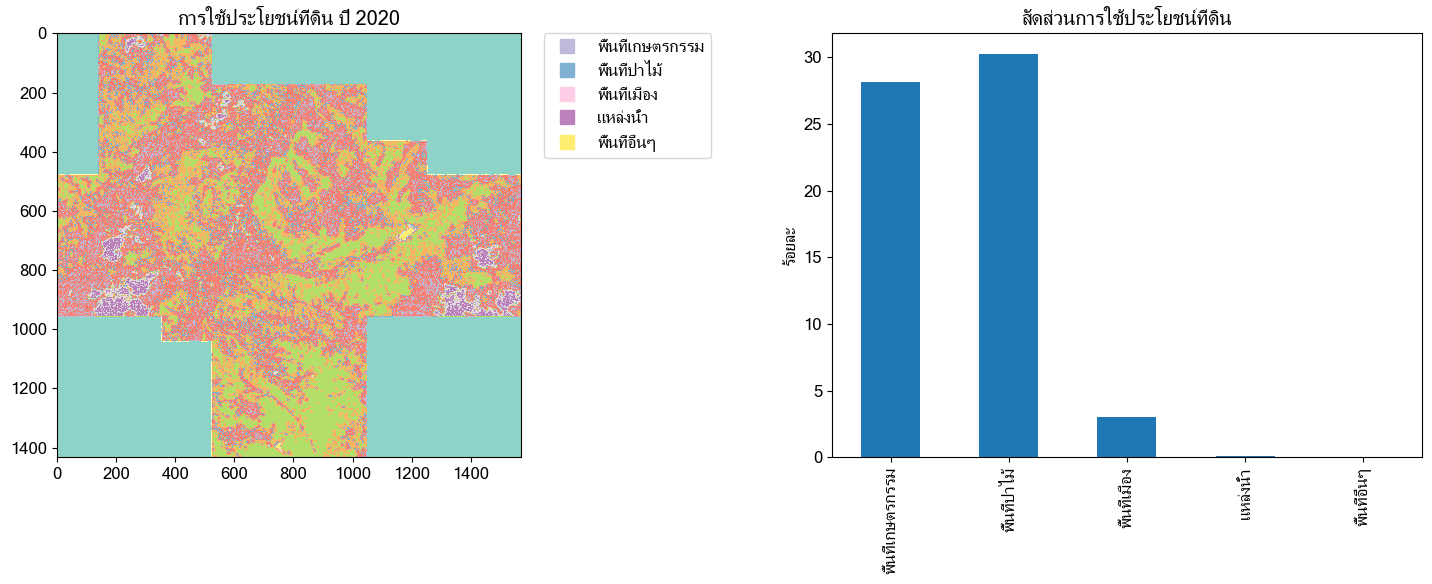

In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import rasterio
from rasterio.plot import show
import folium
from folium import plugins
from sklearn.metrics import confusion_matrix
import os

class LandUseAnalysis:
    def __init__(self, shapefile_path):
        """
        กำหนดค่าเริ่มต้นสำหรับการวิเคราะห์
        """
        self.study_area = gpd.read_file(shapefile_path)
        self.land_use_categories = {
            1: 'พื้นที่เกษตรกรรม',
            2: 'พื้นที่ป่าไม้',
            3: 'พื้นที่เมือง',
            4: 'แหล่งน้ำ',
            5: 'พื้นที่อื่นๆ'
        }
    
    def load_satellite_data(self, raster_path, year):
        """
        โหลดข้อมูลภาพถ่ายดาวเทียม
        """
        with rasterio.open(raster_path) as src:
            self.satellite_data = src.read()
            self.metadata = src.meta
            self.year = year
    
    def classify_land_use(self):
        """
        จำแนกประเภทการใช้ประโยชน์ที่ดิน
        """
        # สมมติว่าใช้วิธีการจำแนกแบบง่าย (ในความเป็นจริงควรใช้ machine learning)
        classified = np.zeros_like(self.satellite_data[0])
        
        # ตัวอย่างการจำแนกอย่างง่าย
        ndvi = (self.satellite_data[3] - self.satellite_data[2]) / (self.satellite_data[3] + self.satellite_data[2])
        
        classified[ndvi > 0.5] = 2  # ป่าไม้
        classified[ndvi < 0] = 4    # แหล่งน้ำ
        classified[(ndvi >= 0) & (ndvi <= 0.2)] = 3  # เมือง
        classified[(ndvi > 0.2) & (ndvi <= 0.5)] = 1  # เกษตรกรรม
        
        self.classified_data = classified

        # save classified data to file with output prefix 'classified_data'
        with rasterio.open('classified_data.tif', 'w', **self.metadata) as dst:
            dst.write(classified, 1)

        return classified
    
    def calculate_area_statistics(self):
        """
        คำนวณสถิติพื้นที่แต่ละประเภท
        """
        stats = {}
        pixel_area = abs(self.metadata['transform'][0] * self.metadata['transform'][4])
        
        for code, name in self.land_use_categories.items():
            area = np.sum(self.classified_data == code) * pixel_area
            percentage = (area / (self.metadata['width'] * self.metadata['height'] * pixel_area)) * 100
            stats[name] = {
                'area_sq_km': area / 1000000,  # แปลงเป็น ตร.กม.
                'percentage': percentage
            }
        
        return pd.DataFrame(stats).T
    
    def create_change_matrix(self, old_classification, new_classification):
        """
        สร้าง matrix แสดงการเปลี่ยนแปลงการใช้ประโยชน์ที่ดิน
        """
        matrix = confusion_matrix(old_classification.flatten(), 
                                new_classification.flatten(),
                                labels=list(self.land_use_categories.keys()))
        
        df_matrix = pd.DataFrame(matrix,
                               index=[f'From {v}' for v in self.land_use_categories.values()],
                               columns=[f'To {v}' for v in self.land_use_categories.values()])
        return df_matrix
    
    def plot_results(self):
        """
        สร้างแผนที่และกราฟแสดงผลการวิเคราะห์
        """
         # ตรวจสอบระบบปฏิบัติการ
        if os.name == 'nt':  # Windows
            # ลองใช้ fonts ที่มักมีในเครื่อง Windows
            font_paths = [
                'c:/Windows/Fonts/THSarabunNew.ttf',
                'c:/Windows/Fonts/Tahoma.ttf',
                'c:/Windows/Fonts/THSarabun.ttf',
                'c:/Windows/Fonts/Angsana.ttf'
            ]
        else:  # MacOS และ Linux
            font_paths = [
                '/usr/share/fonts/thai/THSarabunNew.ttf',
                '/Library/Fonts/THSarabunNew.ttf',
                '/usr/share/fonts/truetype/thai/Sarabun-Regular.ttf'
            ]

        # ค้นหา font ที่ใช้ได้
        font_path = None
        for path in font_paths:
            if os.path.exists(path):
                font_path = path
                break

        if font_path:
            # กำหนด font
            font_prop = fm.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = font_prop.get_name()
        else:
            # ถ้าไม่พบ font ภาษาไทย ให้ใช้ Microsoft Sans Serif
            plt.rcParams['font.family'] = 'Microsoft Sans Serif'

        # ตั้งค่าเพิ่มเติมเพื่อรองรับภาษาไทย
        plt.rcParams['font.size'] = 12
        plt.rcParams['axes.unicode_minus'] = False

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
        
        # แผนที่การใช้ประโยชน์ที่ดิน
        im = ax1.imshow(self.classified_data, cmap='Set3')
        ax1.set_title(f'การใช้ประโยชน์ที่ดิน ปี {self.year}')
        
        # สร้าง legend
        patches = [plt.plot([], [], marker="s", ms=10, ls="", color=plt.cm.Set3(i/5.), 
                          label=name)[0] for i, name in self.land_use_categories.items()]
        ax1.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        # กราฟแสดงสัดส่วนพื้นที่
        stats = self.calculate_area_statistics()
        stats['percentage'].plot(kind='bar', ax=ax2)
        ax2.set_title('สัดส่วนการใช้ประโยชน์ที่ดิน')
        ax2.set_ylabel('ร้อยละ')
        
        plt.tight_layout()
        return fig

def run_analysis(shapefile_path, raster_path_2010, raster_path_2020):
    """
    ฟังก์ชันหลักสำหรับการวิเคราะห์
    """

    # สร้าง instance สำหรับการวิเคราะห์
    analysis = LandUseAnalysis(shapefile_path)

    # วิเคราะห์ข้อมูลปี 2010
    analysis.load_satellite_data(raster_path_2010, 2010)
    classification_2010 = analysis.classify_land_use()
    stats_before = analysis.calculate_area_statistics()
    
    # วิเคราะห์ข้อมูลปี 2020
    analysis.load_satellite_data(raster_path_2020, 2020)
    classification_2020 = analysis.classify_land_use()
    stats_after = analysis.calculate_area_statistics()
    
    # วิเคราะห์การเปลี่ยนแปลง
    change_matrix = analysis.create_change_matrix(classification_2010, classification_2020)
    
    # สร้างแผนที่และกราฟ
    fig = analysis.plot_results()
    
    return stats_before, stats_after, change_matrix, fig


if __name__ == "__main__":
    stats_before, stats_after, change_matrix, figures = run_analysis(
        'data/meatha.shp',
        'sentinel2_data/sentinel2_2020_merged.tif',
        'sentinel2_data/sentinel2_2022_merged.tif'
    )

    print("สถิติพื้นที่ปี 2020")
    print(stats_before)
    print("\nสถิติพื้นที่ปี 2022")
    print(stats_after)
    print("\nMatrix การเปลี่ยนแปลง")
    print(change_matrix)


    # show statistics in a table
    stats_before.style.background_gradient(cmap='viridis', axis=0)

    stats_after.style.background_gradient(cmap='viridis', axis=0)

    change_matrix.style.background_gradient(cmap='viridis', axis=None)

